In [1]:
import json
import torch

model_info = json.load(open("configs/model_info.json"))
pv_info = json.load(open("configs/pv_info.json"))



In [2]:
from sim_pv_transform import create_transformer

sim_to_pv_transformer = create_transformer(pv_info, model_info["model_in_list"])

# test pvs
test_pv = torch.rand(3,16)
sim_vals = sim_to_pv_transformer.untransform(test_pv)
sim_vals

tensor([[ 2.3683e-01,  7.4235e-02,  6.8833e-01,  4.0842e-01, -3.6114e-01,
         -2.7474e-01,  9.6914e+05,  8.5285e-01,  5.7061e+05,  7.3269e-01,
         -8.3708e-01, -2.9663e-01, -3.0115e-01, -7.6836e-01, -2.4966e-01,
         -4.2375e-01],
        [ 1.1954e-01,  7.8708e-01,  7.4151e-01,  4.5661e-01, -2.7174e-01,
         -8.5728e-02,  7.1634e+05,  6.6249e-01,  6.1999e+05,  5.8197e-01,
         -2.9467e-01, -2.8347e-01, -3.9972e-01, -6.8459e-01, -7.9720e-01,
         -4.9568e-01],
        [ 2.7707e-01,  1.3339e+00,  8.8689e-01,  1.4256e-01, -3.8666e-01,
         -4.4423e-01,  5.2488e+05,  9.6179e-01,  4.0927e+05,  5.9097e-01,
         -2.8658e-01, -1.5575e-01, -4.6118e-01, -3.0169e-01, -2.7316e-01,
         -8.8684e-01]])

In [3]:
from injector_surrogate import Surrogate, create_nn_transformers

nn_input_transformer, nn_output_transformer = create_nn_transformers(
    "configs/normalization.json"
)
test_min = torch.tensor(model_info["train_input_mins"]).unsqueeze(0)
test_max = torch.tensor(model_info["train_input_maxs"]).unsqueeze(0)
print(nn_input_transformer(test_min))
print(nn_input_transformer(test_max))


model = torch.load("torch_model.pt").double()
model.eval()

surrogate = Surrogate(
    model,
    model_info["model_in_list"],
    model_info["model_out_list"],
    nn_input_transformer,
    nn_output_transformer
)

surrogate(test_min.double())


tensor([[ 1.0000e-02,  1.0000e-02,  1.0000e-02,  9.9999e-03,  1.0000e-02,
          1.0000e-02, -7.3761e-09,  1.0000e-02,  0.0000e+00,  1.0000e-02,
          1.0000e-02,  1.0000e-02,  1.0000e-02,  1.0000e-02,  1.0000e-02,
          1.0000e-02]], dtype=torch.float64)
tensor([[ 1.0000e+00,  1.0000e+00,  1.0000e-02,  1.0000e+00,  1.0000e+00,
          1.0000e+00, -7.3761e-09,  1.0000e+00,  0.0000e+00,  1.0000e+00,
          1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,
          1.0000e+00]], dtype=torch.float64)


tensor([[1.0022, 1.0074, 1.0006, 1.0000, 1.0000]], dtype=torch.float64)

In [4]:
print(nn_input_transformer.bounds)
print(nn_input_transformer.mins)
print(nn_input_transformer.ranges)


tensor([[ 2.0729e-01,  2.9091e+00,  2.4999e+02,  1.9346e-01, -1.0202e-02,
         -1.0201e-02,  5.8000e+07, -2.5352e+01,  7.0000e+07, -2.5353e+01,
          9.6976e-01, -4.0205e+00,  9.4011e-01, -7.0807e+00, -7.0792e+00,
          9.3944e-01],
        [ 5.0000e-01,  1.1999e+01,  2.5100e+02,  2.5630e-01,  9.9925e-03,
          9.9994e-03,  5.8000e+07,  9.9918e+00,  7.0000e+07,  9.9989e+00,
          3.9982e+00, -1.0105e+00,  6.9998e+00,  9.9835e-01,  9.9930e-01,
          6.9981e+00]], dtype=torch.float64)
tensor([[ 2.0729e-01,  2.9091e+00,  2.4999e+02,  1.9346e-01, -1.0202e-02,
         -1.0201e-02,  5.8000e+07, -2.5352e+01,  7.0000e+07, -2.5353e+01,
          9.6976e-01, -4.0205e+00,  9.4011e-01, -7.0807e+00, -7.0792e+00,
          9.3944e-01]], dtype=torch.float64)
tensor([[2.9271e-01, 9.0895e+00, 1.0101e+00, 6.2841e-02, 2.0194e-02, 2.0201e-02,
         1.0101e+00, 3.5344e+01, 1.0101e+00, 3.5352e+01, 3.0284e+00, 3.0100e+00,
         6.0597e+00, 8.0790e+00, 8.0785e+00, 6.0586e+00]], 

In [5]:
import numpy as np
raw_x_data = np.load("data/x_raw_small.npy", allow_pickle=True)
raw_y_data = np.load("data/y_raw_small.npy", allow_pickle=True)

preds = surrogate(torch.tensor(raw_x_data).double(), return_log=True)


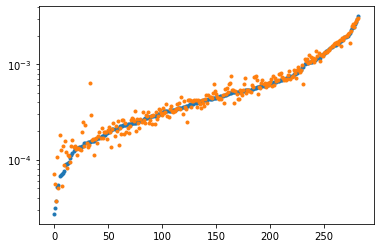

In [6]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
sort_idx = np.argsort(raw_y_data[:,0])

ax.semilogy(raw_y_data[:,0][sort_idx],'.')
ax.semilogy(preds[:,0][sort_idx],'.')


In [7]:
# make predictions using pv values
sim_to_pv_transformer.eval()
test_pv = sim_to_pv_transformer(torch.tensor(raw_x_data[:2]))
sim_vals = sim_to_pv_transformer.untransform(test_pv)
preds = surrogate(sim_vals, return_log=True)